# 实验3论文实验复现 (Lab3 Implement)

Author: 高鹏昺

Email: nbgao@126.com


**复现论文**

[An Analysis of Single Layer Networks in Unsupervised Feature Learning](https://ai.stanford.edu/~ang/papers/nipsdlufl10-AnalysisSingleLayerUnsupervisedFeatureLearning.pdf)


**核心参数**

* 数据集大小: data_num = 1000
* 单张图像采样块数: M = 10
* 采样块/感受野宽度: W = 6
* 感受野滑动步长: S = 1
* 聚类中心数: K = 1000

In [1]:
import numpy as np
import sklearn
import scipy.io as sio
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from skimage import feature as feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# mnist = fetch_mldata('mnist-original', data_home = './data/') 
mnist = sio.loadmat('./data/mnist-original.mat')
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [3]:
data, label = mnist['data'].T, mnist['label'].T.astype('int')

print('data shape:', data.shape)
print('label shape:', label.shape)

data shape: (70000, 784)
label shape: (70000, 1)


In [4]:
index_list = range(data.shape[0])
random_index = random.sample(index_list, 1000)

In [5]:
data = data[random_index]
label = label[random_index]
print(data.shape)
print(label.shape)

(1000, 784)
(1000, 1)


In [6]:
data_num, feature_num = data.shape
print('data_num:', data_num)
print('feature_num:', feature_num)

data_num: 1000
feature_num: 784


## Parameters

In [7]:
M = 10  # 每个图像随机采样的patch数
K = 1000  # 聚类的中心数(特征数)
W = 6  # 采样patch的宽度
S = 1  # 滑动步长

# 1. 特征学习阶段 Feature Learning

## 1.1 Sampling

In [8]:
# 随机采样切块函数
def Sampling(img, w):
    x = np.random.randint(28-w+1)
    y = np.random.randint(28-w+1)
    patch = img[x:x+w, y:y+w]
    return patch

In [9]:
patch_list = np.zeros((data_num*M, W, W))
k = 0
time_start = time.time()
# 对所有训练图像进行分块取样
for i in range(data_num):
    # 每张图像取样M次
    for j in range(M):
        # 分块采样,patch大小为w*w
        img = data[i].reshape(28,28)
        patch = Sampling(img, W)
        patch_list[k] = patch
        k += 1
           
time_end = time.time()
print('Patch Sampling time: {:.1f}s'.format(time_end-time_start))

Patch Sampling time: 0.1s


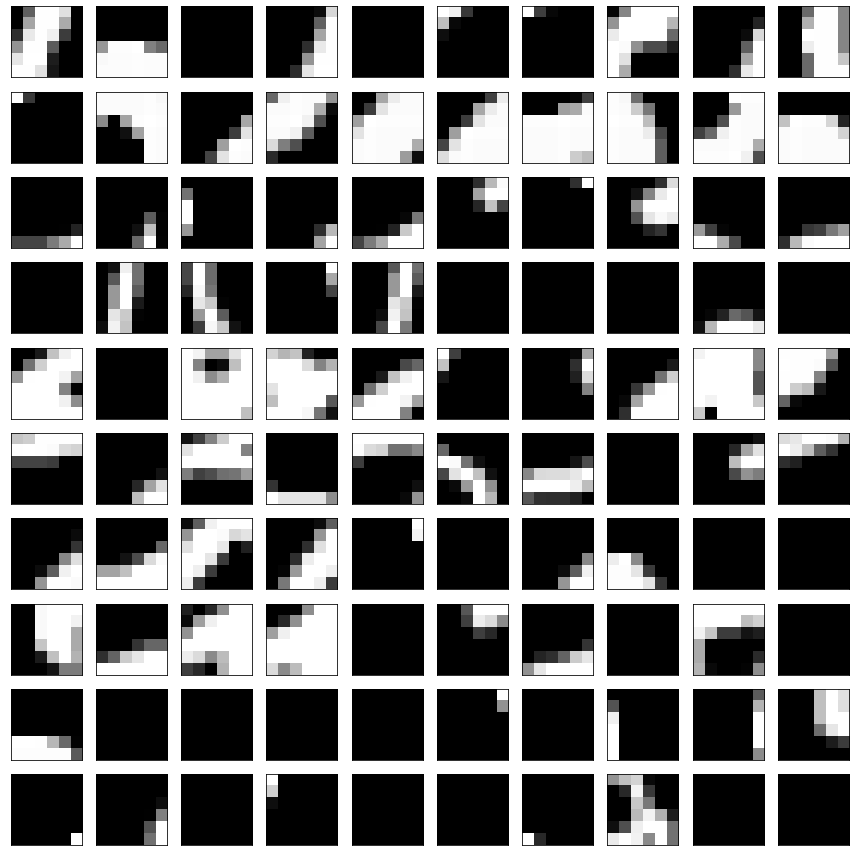

In [10]:
# 随机选取100个patch图显示
patch_num = patch_list.shape[0]
patch_index = random.sample(range(patch_num), 100)
plt.figure(figsize=(12,12))
k = 0
for i in range(1,11):
    for j in range(1,11):
        ax = plt.subplot(10,10,k+1)
        plt.imshow(patch_list[k], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        k += 1
        
plt.tight_layout()

## 1.2 Pre-processing

### 1.2.1 Normalization (Standardization)
#### 采用的是z-score标准化

In [11]:
def Standardization(X):
    u = X.mean()
    s = X.std()
    return (X-u)/(s+1e-6)

In [12]:
time_start = time.time()
patch_ss = patch_list.copy()
for i in range(patch_num):
    patch_ss[i] = Standardization(patch_ss[i])
    
time_end = time.time()
print('Normalization time: {:.1f}s'.format(time_end-time_start))

Normalization time: 0.3s


In [13]:
patch_ss[100]

array([[-0.67530235, -0.67530235, -0.67530235, -0.67530235, -0.67530235,
        -0.67530235],
       [-0.67530235, -0.67530235, -0.67530235, -0.67530235, -0.67530235,
        -0.67530235],
       [-0.67530235, -0.67530235, -0.67530235, -0.67530235, -0.67530235,
        -0.67530235],
       [-0.67530235, -0.44481993, -0.33458921, -0.50494578, -0.13416972,
         0.14641757],
       [-0.67530235,  0.60738241,  1.559375  ,  1.30885063,  1.84998327,
         1.84998327],
       [-0.67530235,  0.87794872,  1.84998327,  1.84998327,  1.84998327,
         1.84998327]])

### 1.2.2 PCA Whitening

In [14]:
def PCA_whitening(X):
    # 减去均值，使得以0为中心
    X -= np.mean(X)
    # 计算协方差矩阵
    cov = np.dot(X.T, X) / X.shape[0]
    # 协方差矩阵奇异值分解SVD
    U,S,V = np.linalg.svd(cov)
    X_rot = np.dot(X, U) 
    X_white = X_rot / np.sqrt(S + 1e-6)
    return X

In [15]:
time_start = time.time()
patch_wh = patch_ss.copy()
for i in range(patch_num):
    patch_wh[i] = PCA_whitening(patch_wh[i])
    
time_end = time.time()
print('PCA-Whitening time: {:.1f}s'.format(time_end-time_start))

PCA-Whitening time: 0.5s


In [16]:
patch_wh[100]

array([[-0.67530235, -0.67530235, -0.67530235, -0.67530235, -0.67530235,
        -0.67530235],
       [-0.67530235, -0.67530235, -0.67530235, -0.67530235, -0.67530235,
        -0.67530235],
       [-0.67530235, -0.67530235, -0.67530235, -0.67530235, -0.67530235,
        -0.67530235],
       [-0.67530235, -0.44481993, -0.33458921, -0.50494578, -0.13416972,
         0.14641757],
       [-0.67530235,  0.60738241,  1.559375  ,  1.30885063,  1.84998327,
         1.84998327],
       [-0.67530235,  0.87794872,  1.84998327,  1.84998327,  1.84998327,
         1.84998327]])

#### ZCA-Whitening

In [1]:
def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #inputs是经过归一化处理的，所以这边就相当于计算协方差矩阵
    U,S,V = np.linalg.svd(sigma) #奇异分解
    epsilon = 0.1                #白化的时候，防止除数为0
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #计算zca白化矩阵
    return np.dot(ZCAMatrix, inputs)   #白化变换

## 1.3 Unsupervised Learning - K-Means

In [17]:
from sklearn.cluster import KMeans

time_start = time.time()
# 将patch_wh的最后一维展平
patch_wh_flatten = patch_wh.reshape(patch_num, -1)
# K = 1000
kmeans = KMeans(n_clusters=K, random_state=0)
kmeans.fit(patch_wh_flatten)

time_end = time.time()
print('K-Means time: {:.1f}s'.format(time_end-time_start))

K-Means time: 23.2s


In [18]:
# 无监督学习到的K个中心
C = kmeans.cluster_centers_
C.shape

(1000, 36)

### Visualization
### 可视化学习到的中心(centroids)

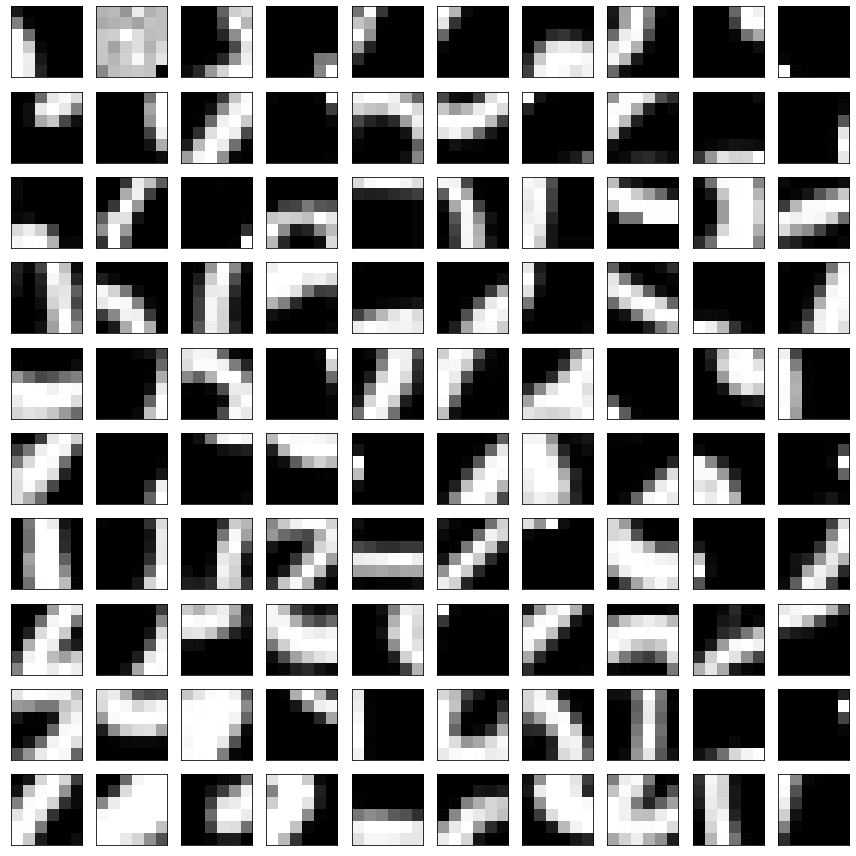

In [19]:
# 随机选取100个中心特征图显示
centroid_index = random.sample(range(K), 100)
plt.figure(figsize=(12,12))
k = 0
for i in range(1,11):
    for j in range(1,11):
        ax = plt.subplot(10,10,k+1)
        img = C[k].reshape(6,6)
        plt.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        k += 1
        
plt.tight_layout()

# 2. Feature Extraction 

## 2.1 Convolutional Extraction


In [20]:
def dist(x, c):
    return np.time_start = time.time()

# 扫描后窗口大小
sn = 28-W+1
f = np.zeros((data_num,2,2,K))
feature = np.zeros((data_num,4*K))
for i in range(data_num):
    img = data[i].reshape(28,28)
    # 23 * 23 * 1600
    y = np.zeros((sn, sn, K))
    # 感受野滑动
    for sx in range(sn):
        for sy in range(sn):
            patch = img[sx:sx+W, sy:sy+W]
            D = np.zeros(K)
            for k in range(K):
                patch_flatten = patch.reshape(W*W)
                D[k] = dist(patch_flatten, C[k])
            min_c = np.argmin(D)
            # 最接近的中心类下标置1
            y[sx][sy][min_c] = 1
            
    # 4象限池化 23*23 -> 2*2
    for k in range(K):
        f[i][0][0][k] = np.time_start = time.time()

# 扫描后窗口大小
sn = 28-W+1
f = np.zeros((data_num,2,2,K))
feature = np.zeros((data_num,4*K))
for i in range(data_num):
    time1 = time.time()
    img = data[i].reshape(28,28)
    # 23 * 23 * 1600
    y = np.zeros((sn, sn, K))
    # 感受野滑动
    for sx in range(sn):
        for sy in range(sn):
            patch = img[sx:sx+W, sy:sy+W]
            D = np.zeros(K)
            for k in range(K):
                patch_flatten = patch.reshape(W*W)
                D[k] = dist(patch_flatten, C[k])
            min_c = np.argmin(D)
            # 最接近的中心类下标置1
            y[sx][sy][min_c] = 1
            
    # 4象限池化 23*23 -> 2*2
    for k in range(K):
        f[i][0][0][k] = np.mean(y[:sn//2, :sn//2, k])
        f[i][0][1][k] = np.mean(y[:sn//2, sn//2:, k])
        f[i][1][0][k] = np.mean(y[sn//2:, :sn//2, k])
        f[i][1][1][k] = np.mean(y[sn//2:, sn//2:, k])
    
    # 最后一维拼接
    feature[i] = f[i].reshape(4*K)
    time2 = time.time()
    print('Step: {:d}, time: {:.2f}s'.format(i, time2-time1))

time_end = time.time()
print('Feature Extraction time: {:.1f}s'.format(time_end-time_start))mean(y[:sn//2, :sn//2, k])
        f[i][0][1][k] = np.mean(y[:sn//2, sn//2:, k])
        f[i][1][0][k] = np.mean(y[sn//2:, :sn//2, k])
        f[i][1][1][k] = np.mean(y[sn//2:, sn//2:, k])
    
    # 最后一维拼接
    feature[i] = f[i].reshape(4*K)
    if i%500 == 0:
        print('Step: ', i)

time_end = time.time()
print('Feature Extraction time: {:.1f}s'.format(time_end-time_start))sum(np.square(x-c))

In [68]:
time_start = time.time()

# 扫描后窗口大小
sn = 28-W+1
f = np.zeros((data_num,2,2,K))
feature = np.zeros((data_num,4*K))
for i in range(data_num):
    time1 = time.time()
    img = data[i].reshape(28,28)
    # 23 * 23 * 1600
    y = np.zeros((sn, sn, K))
    # 感受野滑动
    for sx in range(sn):
        for sy in range(sn):
            patch = img[sx:sx+W, sy:sy+W]
            D = np.zeros(K)
            for k in range(K):
                patch_flatten = patch.reshape(W*W)
                D[k] = dist(patch_flatten, C[k])
            min_c = np.argmin(D)
            # 最接近的中心类下标置1
            y[sx][sy][min_c] = 1
            
    # 4象限平均池化 23*23 -> 2*2
    for k in range(K):
        f[i][0][0][k] = np.mean(y[:sn//2, :sn//2, k])
        f[i][0][1][k] = np.mean(y[:sn//2, sn//2:, k])
        f[i][1][0][k] = np.mean(y[sn//2:, :sn//2, k])
        f[i][1][1][k] = np.mean(y[sn//2:, sn//2:, k])
    
    # 最后一维拼接
    feature[i] = f[i].reshape(4*K)
    time2 = time.time()
    print('Step: {:d}, time: {:.2f}s'.format(i, time2-time1))

time_end = time.time()
print('Feature Extraction time: {:.1f}s'.format(time_end-time_start))

Step: 0, time: 3.82s
Step: 1, time: 3.82s
Step: 2, time: 3.74s
Step: 3, time: 3.78s
Step: 4, time: 3.76s
Step: 5, time: 3.79s
Step: 6, time: 3.83s
Step: 7, time: 3.76s
Step: 8, time: 3.70s
Step: 9, time: 3.65s
Step: 10, time: 3.61s
Step: 11, time: 3.62s
Step: 12, time: 3.74s
Step: 13, time: 3.91s
Step: 14, time: 3.75s
Step: 15, time: 3.71s
Step: 16, time: 3.75s
Step: 17, time: 3.76s
Step: 18, time: 3.71s
Step: 19, time: 3.75s
Step: 20, time: 3.73s
Step: 21, time: 3.71s
Step: 22, time: 3.74s
Step: 23, time: 3.90s
Step: 24, time: 3.76s
Step: 25, time: 3.75s
Step: 26, time: 3.77s
Step: 27, time: 3.79s
Step: 28, time: 3.72s
Step: 29, time: 3.75s
Step: 30, time: 3.73s
Step: 31, time: 3.75s
Step: 32, time: 3.74s
Step: 33, time: 3.83s
Step: 34, time: 3.81s
Step: 35, time: 4.00s
Step: 36, time: 3.82s
Step: 37, time: 3.86s
Step: 38, time: 3.94s
Step: 39, time: 3.88s
Step: 40, time: 3.93s
Step: 41, time: 3.73s
Step: 42, time: 3.76s
Step: 43, time: 3.82s
Step: 44, time: 3.85s
Step: 45, time: 3.92

Step: 361, time: 3.82s
Step: 362, time: 3.80s
Step: 363, time: 3.80s
Step: 364, time: 3.83s
Step: 365, time: 3.81s
Step: 366, time: 3.80s
Step: 367, time: 3.80s
Step: 368, time: 3.79s
Step: 369, time: 3.82s
Step: 370, time: 3.83s
Step: 371, time: 3.81s
Step: 372, time: 3.75s
Step: 373, time: 3.79s
Step: 374, time: 3.80s
Step: 375, time: 3.85s
Step: 376, time: 3.81s
Step: 377, time: 3.79s
Step: 378, time: 3.74s
Step: 379, time: 3.75s
Step: 380, time: 3.81s
Step: 381, time: 3.79s
Step: 382, time: 3.94s
Step: 383, time: 3.79s
Step: 384, time: 5.00s
Step: 385, time: 8.88s
Step: 386, time: 5.14s
Step: 387, time: 3.78s
Step: 388, time: 3.82s
Step: 389, time: 3.82s
Step: 390, time: 3.80s
Step: 391, time: 3.76s
Step: 392, time: 3.79s
Step: 393, time: 3.76s
Step: 394, time: 3.78s
Step: 395, time: 3.78s
Step: 396, time: 3.82s
Step: 397, time: 3.77s
Step: 398, time: 3.79s
Step: 399, time: 3.75s
Step: 400, time: 3.76s
Step: 401, time: 3.83s
Step: 402, time: 3.85s
Step: 403, time: 3.79s
Step: 404, 

Step: 718, time: 3.85s
Step: 719, time: 3.85s
Step: 720, time: 3.87s
Step: 721, time: 3.80s
Step: 722, time: 3.83s
Step: 723, time: 3.86s
Step: 724, time: 3.83s
Step: 725, time: 3.84s
Step: 726, time: 3.80s
Step: 727, time: 3.78s
Step: 728, time: 3.76s
Step: 729, time: 3.78s
Step: 730, time: 3.84s
Step: 731, time: 3.86s
Step: 732, time: 3.83s
Step: 733, time: 3.82s
Step: 734, time: 3.83s
Step: 735, time: 3.75s
Step: 736, time: 3.79s
Step: 737, time: 3.71s
Step: 738, time: 3.72s
Step: 739, time: 3.69s
Step: 740, time: 3.75s
Step: 741, time: 3.71s
Step: 742, time: 3.70s
Step: 743, time: 3.73s
Step: 744, time: 3.73s
Step: 745, time: 3.72s
Step: 746, time: 3.71s
Step: 747, time: 3.70s
Step: 748, time: 3.76s
Step: 749, time: 3.72s
Step: 750, time: 3.84s
Step: 751, time: 3.86s
Step: 752, time: 3.82s
Step: 753, time: 3.82s
Step: 754, time: 3.89s
Step: 755, time: 4.23s
Step: 756, time: 3.73s
Step: 757, time: 3.72s
Step: 758, time: 3.72s
Step: 759, time: 3.75s
Step: 760, time: 3.74s
Step: 761, 

In [31]:
feature.shape

(1000, 4000)

In [69]:
# 保存特征
np.save('./data/feature_1.npy', feature)
# feature = np.load('./data/feature_1.npy')

# 3. Classification
使用LinearSVM L2作为分类器模型进行训练和预测

### Split Dataset

In [185]:
feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=1/10)
print('feature_train.shape:', feature_train.shape)
print('feature_test.shape:', feature_test.shape)

feature_train.shape: (900, 4000)
feature_test.shape: (100, 4000)


### Train

In [186]:
from sklearn.svm import LinearSVC

svc_l2 = LinearSVC(penalty='l2')
svc_l2.fit(feature_train, label_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Test

In [187]:
label_predict = svc_l2.predict(feature_test)

In [188]:
# Result Evaluation
print('The Accuracy of Linear SVM:', svc_l2.score(feature_test, label_test))
print(classification_report(label_test, label_predict))

The Accuracy of Linear SVM: 0.88
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.70      0.88      0.78         8
           2       0.77      0.83      0.80        12
           3       0.78      0.88      0.82         8
           4       1.00      0.88      0.94        17
           5       0.83      0.83      0.83         6
           6       0.92      1.00      0.96        11
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         7
           9       1.00      0.67      0.80         6

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100



### K-Fold Cross Validation (K折交叉验证)

In [184]:
from sklearn.model_selection import cross_val_score

svc_l2 = LinearSVC(penalty='l2')

# K折交叉验证(K=10)
scores = cross_val_score(svc_l2, feature, label, cv=10)
for i, score in enumerate(scores):
    print('{:d}: {:.3f}'.format(i, score))

# 平均准确率
print('Average Accuracy: {:.3f}'.format(scores.mean()) )

0: 0.865
1: 0.874
2: 0.912
3: 0.824
4: 0.900
5: 0.859
6: 0.869
7: 0.898
8: 0.887
9: 0.896
Average Accuracy: 0.878


## Soft (triangle)

In [199]:
time_start = time.time()

# 扫描后窗口大小
sn = 28-W+1
f2 = np.zeros((data_num,2,2,K))
feature2 = np.zeros((data_num,4*K))
for i in range(data_num):
    time1 = time.time()
    img = data[i].reshape(28,28)
    # 23 * 23 * 1600
    y = np.zeros((sn, sn, K))
    y1 = np.zeros((sn, sn, K))
    # 感受野滑动
    for sx in range(sn):
        for sy in range(sn):
            patch = img[sx:sx+W, sy:sy+W]
            D = np.zeros(K)
            for k in range(K):
                patch_flatten = patch.reshape(W*W)
                D[k] = dist(patch_flatten, C[k])
            u = D.mean()
            # triangle activation function
            for k in range(K):
                if(D[k]<u):
                    y[sx, sy, k] = u - D[k]
#                 y[sx][sy][k] = max(0,u-D[k])        
    # 4象限平均池化 23*23 -> 2*2
    for k in range(K):
        f[i][0][0][k] = np.mean(y[:sn//2, :sn//2, k])
        f[i][0][1][k] = np.mean(y[:sn//2, sn//2:, k])
        f[i][1][0][k] = np.mean(y[sn//2:, :sn//2, k])
        f[i][1][1][k] = np.mean(y[sn//2:, sn//2:, k])
    
    # 最后一维拼接
    feature2[i] = f[i].reshape(4*K)
    time2 = time.time()
    print('Step: {:d}, time: {:.2f}s'.format(i, time2-time1))

time_end = time.time()
print('Feature Extraction time: {:.1f}s'.format(time_end-time_start))

Step: 0, time: 4.98s
Step: 1, time: 3.92s
Step: 2, time: 3.82s
Step: 3, time: 6.05s
Step: 4, time: 3.75s
Step: 5, time: 3.76s
Step: 6, time: 3.85s
Step: 7, time: 3.81s
Step: 8, time: 3.89s
Step: 9, time: 3.87s
Step: 10, time: 3.92s
Step: 11, time: 3.84s
Step: 12, time: 3.80s
Step: 13, time: 3.77s
Step: 14, time: 3.74s
Step: 15, time: 3.81s
Step: 16, time: 3.76s
Step: 17, time: 3.74s
Step: 18, time: 3.75s
Step: 19, time: 3.73s
Step: 20, time: 3.74s
Step: 21, time: 3.79s
Step: 22, time: 3.93s
Step: 23, time: 3.82s
Step: 24, time: 3.81s
Step: 25, time: 3.78s
Step: 26, time: 3.77s
Step: 27, time: 3.77s
Step: 28, time: 3.78s
Step: 29, time: 3.85s
Step: 30, time: 3.74s
Step: 31, time: 3.83s
Step: 32, time: 3.85s
Step: 33, time: 3.74s
Step: 34, time: 3.77s
Step: 35, time: 3.77s
Step: 36, time: 3.74s
Step: 37, time: 3.83s
Step: 38, time: 3.77s
Step: 39, time: 3.73s
Step: 40, time: 3.76s
Step: 41, time: 3.82s
Step: 42, time: 3.79s
Step: 43, time: 3.76s
Step: 44, time: 3.76s
Step: 45, time: 3.79

Step: 361, time: 3.72s
Step: 362, time: 3.62s
Step: 363, time: 3.60s
Step: 364, time: 3.62s
Step: 365, time: 3.59s
Step: 366, time: 3.62s
Step: 367, time: 3.63s
Step: 368, time: 3.72s
Step: 369, time: 3.85s
Step: 370, time: 3.74s
Step: 371, time: 3.74s
Step: 372, time: 3.66s
Step: 373, time: 3.67s
Step: 374, time: 3.68s
Step: 375, time: 3.68s
Step: 376, time: 3.72s
Step: 377, time: 3.61s
Step: 378, time: 3.67s
Step: 379, time: 3.66s
Step: 380, time: 3.75s
Step: 381, time: 3.75s
Step: 382, time: 3.65s
Step: 383, time: 3.80s
Step: 384, time: 3.82s
Step: 385, time: 3.73s
Step: 386, time: 3.72s
Step: 387, time: 3.66s
Step: 388, time: 3.69s
Step: 389, time: 3.64s
Step: 390, time: 3.69s
Step: 391, time: 3.64s
Step: 392, time: 3.73s
Step: 393, time: 3.73s
Step: 394, time: 3.68s
Step: 395, time: 3.74s
Step: 396, time: 3.84s
Step: 397, time: 3.65s
Step: 398, time: 3.65s
Step: 399, time: 3.64s
Step: 400, time: 3.63s
Step: 401, time: 3.66s
Step: 402, time: 3.68s
Step: 403, time: 3.72s
Step: 404, 

Step: 718, time: 3.68s
Step: 719, time: 3.66s
Step: 720, time: 3.70s
Step: 721, time: 3.69s
Step: 722, time: 3.72s
Step: 723, time: 3.78s
Step: 724, time: 3.80s
Step: 725, time: 3.86s
Step: 726, time: 3.86s
Step: 727, time: 3.83s
Step: 728, time: 3.87s
Step: 729, time: 3.72s
Step: 730, time: 3.69s
Step: 731, time: 3.64s
Step: 732, time: 3.63s
Step: 733, time: 3.64s
Step: 734, time: 3.67s
Step: 735, time: 3.66s
Step: 736, time: 3.67s
Step: 737, time: 3.64s
Step: 738, time: 3.62s
Step: 739, time: 3.65s
Step: 740, time: 3.66s
Step: 741, time: 3.64s
Step: 742, time: 3.64s
Step: 743, time: 3.66s
Step: 744, time: 3.63s
Step: 745, time: 3.64s
Step: 746, time: 3.65s
Step: 747, time: 3.64s
Step: 748, time: 3.63s
Step: 749, time: 3.63s
Step: 750, time: 3.67s
Step: 751, time: 3.63s
Step: 752, time: 3.65s
Step: 753, time: 3.67s
Step: 754, time: 3.65s
Step: 755, time: 3.63s
Step: 756, time: 3.72s
Step: 757, time: 3.73s
Step: 758, time: 3.80s
Step: 759, time: 3.67s
Step: 760, time: 3.67s
Step: 761, 

### K-Fold Cross Validation (K折交叉验证)

In [202]:
from sklearn.model_selection import cross_val_score

feature2_train, feature2_test, label_train, label_test = train_test_split(feature2, label, test_size=1/10)

svc_l2 = LinearSVC(penalty='l2')

# K折交叉验证(K=10)
scores = cross_val_score(svc_l2, feature2, label, cv=10)
for i, score in enumerate(scores):
    print('{:d}: {:.3f}'.format(i, score))

# 平均准确率
print('Average Accuracy: {:.3f}'.format(scores.mean()) )

0: 0.913
1: 0.981
2: 0.961
3: 0.961
4: 0.960
5: 0.939
6: 0.939
7: 0.929
8: 0.969
9: 0.958
Average Accuracy: 0.951
